In [1]:
import os
from src.util import plotting_util as putil
import pandas as pd
import fnmatch
from src.util import eval_util as eutil
import seaborn as sns

REPO_DIR = os.path.join(os.getcwd(), "../")
os.chdir(REPO_DIR)


CUDA GPU: False


In [23]:
SITES = ["m5", "m8"]
MIG_TYPES = ["mS", "M", "S", "R"]
CUTOFF = 1.0
k = 100000
LOSS_THRES=0.5

DATE = "12062023"
PARAMS = "calibrate_solvepoly_wip_gen0.2"

tot 1647
29


<Axes: xlabel='clusters', ylabel='Count'>

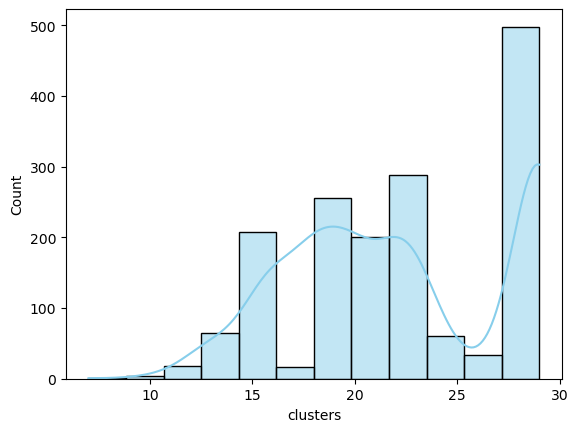

In [24]:

# Get number of clusters (tree vertices to label) per site/mig_type/seed combo
def get_num_mut_trees(mut_tree_fn):
    with open(mut_tree_fn, 'r') as f:
        # look for line w/ "3 #trees" as an example
        for line in f:
            if  "#trees" in line:
                return int(line.strip().split()[0])
sims_dir = os.path.join(REPO_DIR, "data/machina_sims")
data = []
tot = 0
for site in SITES:
    for mig_type in MIG_TYPES:
        site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
        seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
        seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
        for seed in seeds:
            fn = os.path.join(site_mig_type_dir, f"clustering_observed_seed{seed}.txt")
            num_lines = sum(1 for _ in open(fn))
            fn = os.path.join(site_mig_type_dir, f"T_seed{seed}.labeling")
            sites = set()
            with open(fn) as f:
                for line in f:
                    sites.add(line.strip().split()[1])
            n = get_num_mut_trees(os.path.join(sims_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"))
            #print(n)
            tot+=n
            for i in range(n):
                data.append([seed, site, mig_type, num_lines, len(sites), i])
print("tot",tot)
cols = ["seed", "site", "mig_type", "clusters", "sites", "tree_num"]
cluster_num_df = pd.DataFrame(data, columns=cols)
cluster_num_df["seed"] = cluster_num_df["seed"].astype(int)
print(cluster_num_df['clusters'].max())

cluster_num_df['cluster_bins'] = pd.qcut(cluster_num_df['clusters'], 3, labels=False, duplicates='drop')
denom=10000
def calc_prob_size(num_sites, num_nodes):
    return (num_sites**(num_nodes-1))
cluster_num_df['prob_size'] = cluster_num_df.apply(lambda row: calc_prob_size(row["sites"], row['clusters'])/denom, axis=1)
cluster_num_df['prob_size_bins'] = pd.qcut(cluster_num_df['prob_size'], 3, labels=False, duplicates='drop')

sns.histplot(cluster_num_df['clusters'], kde=True, color='skyblue')


### Evaluate Metient's best trees based on batch size, tree size and number of anatomical sites

In [25]:
from tqdm import tqdm

batch_sizes = ['64', '256', '1024']
num_runs = 5

bs_to_num_nodes_to_ground_truth_slns = {bs:{} for bs in batch_sizes}
bs_to_num_sites_to_ground_truth_slns = {bs:{} for bs in batch_sizes}
bs_to_prob_size_bin_to_ground_truth_slns = {bs:{} for bs in batch_sizes}

for bs in batch_sizes:
    for run in range(1,num_runs+1):
        prediction_dir = os.path.join(REPO_DIR, 'test', 'machina_simulated_data', f'sample_size_experiments_{PARAMS}_{DATE}/predictions_batch_exp_bs{bs}_{PARAMS}_r{run}_{DATE}')

        print(prediction_dir)
        grad_m5_f1_scores = []
        grad_m8_f1_scores = []
        ct = 0
        tot = 0
        for site in SITES:
            for mig_type in tqdm(MIG_TYPES):
                true_site_mig_type_data_dir = os.path.join(sims_dir, site, mig_type)
                predicted_site_mig_type_data_dir = os.path.join(prediction_dir, site, mig_type)
                filenames = fnmatch.filter(os.listdir(predicted_site_mig_type_data_dir), 'T_tree*.predicted.tree')
                seeds = set([int(s[s.find("seed")+4:s.find(".predicted")]) for s in filenames])
                for seed in seeds:
                    seed_filenames = [f for f in filenames if seed == f[f.find("seed")+4:f.find(".predicted")]]
                    tree_info = eutil.get_metient_min_loss_trees(predicted_site_mig_type_data_dir, seed, k, loss_thres=LOSS_THRES)
                    ground_truth_clones_found = False
                    ground_truth_mig_graph_found = False
                    Fs, F_G2s = [], []

                    for i, (loss, met_results_dict, met_tree_num) in enumerate(tree_info):
                        recall, precision, F, has_resolved_polytomy = eutil.evaluate_seeding_clones(os.path.join(true_site_mig_type_data_dir, f"T_seed{seed}.tree"),
                                                                      os.path.join(true_site_mig_type_data_dir, f"T_seed{seed}.vertex.labeling"),
                                                                      met_results_dict, met_tree_num)

                        if F >= CUTOFF:
                            ground_truth_clones_found = True

                        recall_G2, precision_G2, F_G2 = eutil.evaluate_migration_multigraph(os.path.join(true_site_mig_type_data_dir, f"G_seed{seed}.tree"),
                                                                                            met_results_dict, met_tree_num)
                        if F_G2 >= CUTOFF:
                            ground_truth_mig_graph_found = True   
                        Fs.append(F)
                        F_G2s.append(F_G2)
                    subset_df = cluster_num_df[(cluster_num_df['seed']==int(seed))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==mig_type)]
                    num_nodes = subset_df.iloc[0]['clusters']
                    rng = subset_df['cluster_bins'].unique().item()
                    if rng not in bs_to_num_nodes_to_ground_truth_slns[bs]:
                        bs_to_num_nodes_to_ground_truth_slns[bs][rng] = []
                    if sum(Fs)/len(Fs) < min(Fs):
                        ct += 1
                    tot+= 1
                    info = (ground_truth_clones_found, ground_truth_mig_graph_found, sum(Fs)/len(Fs), sum(F_G2s)/len(F_G2s))
                    bs_to_num_nodes_to_ground_truth_slns[bs][rng].append(info)

                    num_sites = subset_df.iloc[0]['sites']
                    if num_sites not in bs_to_num_sites_to_ground_truth_slns[bs]:
                        bs_to_num_sites_to_ground_truth_slns[bs][num_sites] = []
                    bs_to_num_sites_to_ground_truth_slns[bs][num_sites].append(info)
                    
                    prob_size_bin = subset_df['prob_size_bins'].unique().item()
                    if prob_size_bin not in bs_to_prob_size_bin_to_ground_truth_slns[bs]:
                        bs_to_prob_size_bin_to_ground_truth_slns[bs][prob_size_bin] = []
                    bs_to_prob_size_bin_to_ground_truth_slns[bs][prob_size_bin].append(info)

bs_to_prob_size_bin_to_ground_truth_slns


/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs64_calibrate_solvepoly_wip_gen0.2_r1_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 3
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3


 25%|██▌       | 1/4 [00:00<00:00,  3.81it/s]

# min loss trees: 7
# min loss trees: 2
# min loss trees: 18
# min loss trees: 11
# min loss trees: 11
# min loss trees: 4
# min loss trees: 4
# min loss trees: 11
# min loss trees: 8
# min loss trees: 2
# min loss trees: 8


 50%|█████     | 2/4 [00:01<00:01,  1.25it/s]

# min loss trees: 19
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 9
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:01<00:00,  1.54it/s]

# min loss trees: 10
# min loss trees: 1
# min loss trees: 25
# min loss trees: 39
# min loss trees: 19
# min loss trees: 6
# min loss trees: 6


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


# min loss trees: 6
# min loss trees: 1
# min loss trees: 7
# min loss trees: 7


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 8
# min loss trees: 10
# min loss trees: 15
# min loss trees: 5
# min loss trees: 4
# min loss trees: 3
# min loss trees: 2
# min loss trees: 12


 25%|██▌       | 1/4 [00:01<00:03,  1.17s/it]

# min loss trees: 44
# min loss trees: 18
# min loss trees: 7
# min loss trees: 11
# min loss trees: 4
# min loss trees: 3
# min loss trees: 3
# min loss trees: 9
# min loss trees: 5


 50%|█████     | 2/4 [00:03<00:03,  1.87s/it]

# min loss trees: 28
# min loss trees: 4
# min loss trees: 101
# min loss trees: 58
# min loss trees: 7
# min loss trees: 11
# min loss trees: 16
# min loss trees: 5
# min loss trees: 5
# min loss trees: 3
# min loss trees: 8


 75%|███████▌  | 3/4 [00:08<00:03,  3.16s/it]

# min loss trees: 16
# min loss trees: 4
# min loss trees: 17
# min loss trees: 6
# min loss trees: 1
# min loss trees: 4
# min loss trees: 15
# min loss trees: 3
# min loss trees: 4
# min loss trees: 3
# min loss trees: 25


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs64_calibrate_solvepoly_wip_gen0.2_r2_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 3
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6


 25%|██▌       | 1/4 [00:00<00:00,  3.22it/s]

# min loss trees: 3
# min loss trees: 8
# min loss trees: 2
# min loss trees: 18
# min loss trees: 11
# min loss trees: 11
# min loss trees: 4
# min loss trees: 4
# min loss trees: 11
# min loss trees: 8
# min loss trees: 2
# min loss trees: 8


 50%|█████     | 2/4 [00:01<00:01,  1.00it/s]

# min loss trees: 19
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 9
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.23it/s]

# min loss trees: 10
# min loss trees: 1
# min loss trees: 24
# min loss trees: 39
# min loss trees: 19
# min loss trees: 6
# min loss trees: 7


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


# min loss trees: 6
# min loss trees: 1
# min loss trees: 7
# min loss trees: 7


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 8
# min loss trees: 10
# min loss trees: 17
# min loss trees: 5
# min loss trees: 4
# min loss trees: 2
# min loss trees: 2
# min loss trees: 13


 25%|██▌       | 1/4 [00:01<00:03,  1.29s/it]

# min loss trees: 43
# min loss trees: 18
# min loss trees: 7
# min loss trees: 11
# min loss trees: 4
# min loss trees: 3
# min loss trees: 3
# min loss trees: 8
# min loss trees: 5


 50%|█████     | 2/4 [00:03<00:03,  1.82s/it]

# min loss trees: 28
# min loss trees: 4
# min loss trees: 98
# min loss trees: 58
# min loss trees: 7
# min loss trees: 10
# min loss trees: 16
# min loss trees: 5
# min loss trees: 5
# min loss trees: 4
# min loss trees: 6


 75%|███████▌  | 3/4 [00:07<00:03,  3.00s/it]

# min loss trees: 16
# min loss trees: 4
# min loss trees: 17
# min loss trees: 6
# min loss trees: 1
# min loss trees: 4
# min loss trees: 15
# min loss trees: 3
# min loss trees: 4
# min loss trees: 3
# min loss trees: 20


100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs64_calibrate_solvepoly_wip_gen0.2_r3_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 3
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3


 25%|██▌       | 1/4 [00:00<00:00,  3.98it/s]

# min loss trees: 8
# min loss trees: 2
# min loss trees: 18
# min loss trees: 10
# min loss trees: 11
# min loss trees: 4
# min loss trees: 4
# min loss trees: 11
# min loss trees: 8
# min loss trees: 2
# min loss trees: 8


 50%|█████     | 2/4 [00:01<00:01,  1.24it/s]

# min loss trees: 19
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 9
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:01<00:00,  1.54it/s]

# min loss trees: 10
# min loss trees: 1
# min loss trees: 22
# min loss trees: 39
# min loss trees: 19
# min loss trees: 6
# min loss trees: 7


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


# min loss trees: 6
# min loss trees: 1
# min loss trees: 2
# min loss trees: 7


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 9
# min loss trees: 7
# min loss trees: 10
# min loss trees: 15
# min loss trees: 5
# min loss trees: 3
# min loss trees: 2
# min loss trees: 2
# min loss trees: 12


 25%|██▌       | 1/4 [00:01<00:03,  1.26s/it]

# min loss trees: 43
# min loss trees: 18
# min loss trees: 7
# min loss trees: 11
# min loss trees: 4
# min loss trees: 3
# min loss trees: 2
# min loss trees: 8
# min loss trees: 5


 50%|█████     | 2/4 [00:03<00:03,  1.75s/it]

# min loss trees: 28
# min loss trees: 4
# min loss trees: 98
# min loss trees: 58
# min loss trees: 7
# min loss trees: 10
# min loss trees: 23
# min loss trees: 5
# min loss trees: 5
# min loss trees: 4
# min loss trees: 6


 75%|███████▌  | 3/4 [00:07<00:02,  2.74s/it]

# min loss trees: 16
# min loss trees: 4
# min loss trees: 16
# min loss trees: 6
# min loss trees: 1
# min loss trees: 4
# min loss trees: 15
# min loss trees: 3
# min loss trees: 4
# min loss trees: 3
# min loss trees: 20


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs64_calibrate_solvepoly_wip_gen0.2_r4_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 1
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3


 25%|██▌       | 1/4 [00:00<00:00,  3.86it/s]

# min loss trees: 7
# min loss trees: 2
# min loss trees: 18
# min loss trees: 11
# min loss trees: 11
# min loss trees: 4
# min loss trees: 4
# min loss trees: 11
# min loss trees: 8
# min loss trees: 2
# min loss trees: 8


 50%|█████     | 2/4 [00:01<00:01,  1.17it/s]

# min loss trees: 19
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 9
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.45it/s]

# min loss trees: 5
# min loss trees: 1
# min loss trees: 23
# min loss trees: 39
# min loss trees: 19
# min loss trees: 5
# min loss trees: 7


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


# min loss trees: 6
# min loss trees: 1
# min loss trees: 2
# min loss trees: 7


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 9
# min loss trees: 8
# min loss trees: 10
# min loss trees: 16
# min loss trees: 4
# min loss trees: 4
# min loss trees: 2
# min loss trees: 2
# min loss trees: 12


 25%|██▌       | 1/4 [00:01<00:04,  1.35s/it]

# min loss trees: 43
# min loss trees: 18
# min loss trees: 7
# min loss trees: 11
# min loss trees: 4
# min loss trees: 3
# min loss trees: 3
# min loss trees: 9
# min loss trees: 5
# min loss trees: 28
# min loss trees: 4


 50%|█████     | 2/4 [00:03<00:03,  1.85s/it]

# min loss trees: 101
# min loss trees: 58
# min loss trees: 7
# min loss trees: 11
# min loss trees: 16
# min loss trees: 5
# min loss trees: 5
# min loss trees: 4
# min loss trees: 6


 75%|███████▌  | 3/4 [00:07<00:02,  2.78s/it]

# min loss trees: 16
# min loss trees: 4
# min loss trees: 16
# min loss trees: 6
# min loss trees: 1
# min loss trees: 4
# min loss trees: 15
# min loss trees: 3
# min loss trees: 4
# min loss trees: 3
# min loss trees: 25


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs64_calibrate_solvepoly_wip_gen0.2_r5_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 3
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3


 25%|██▌       | 1/4 [00:00<00:00,  3.96it/s]

# min loss trees: 8
# min loss trees: 2
# min loss trees: 18
# min loss trees: 10
# min loss trees: 11
# min loss trees: 4
# min loss trees: 4
# min loss trees: 11
# min loss trees: 9
# min loss trees: 2
# min loss trees: 8


 50%|█████     | 2/4 [00:01<00:01,  1.25it/s]

# min loss trees: 19
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 9
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:01<00:00,  1.55it/s]

# min loss trees: 5
# min loss trees: 1
# min loss trees: 22
# min loss trees: 39
# min loss trees: 19
# min loss trees: 6
# min loss trees: 7


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


# min loss trees: 5
# min loss trees: 1
# min loss trees: 2
# min loss trees: 7


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 3
# min loss trees: 7
# min loss trees: 10
# min loss trees: 16
# min loss trees: 4
# min loss trees: 4
# min loss trees: 3
# min loss trees: 2
# min loss trees: 12


 25%|██▌       | 1/4 [00:01<00:03,  1.18s/it]

# min loss trees: 43
# min loss trees: 18
# min loss trees: 9
# min loss trees: 11
# min loss trees: 3
# min loss trees: 3
# min loss trees: 2
# min loss trees: 9
# min loss trees: 5


 50%|█████     | 2/4 [00:03<00:03,  1.88s/it]

# min loss trees: 28
# min loss trees: 4
# min loss trees: 101
# min loss trees: 58
# min loss trees: 7
# min loss trees: 10
# min loss trees: 23
# min loss trees: 5
# min loss trees: 5
# min loss trees: 3
# min loss trees: 6


 75%|███████▌  | 3/4 [00:07<00:02,  2.84s/it]

# min loss trees: 16
# min loss trees: 4
# min loss trees: 16
# min loss trees: 6
# min loss trees: 1
# min loss trees: 4
# min loss trees: 15
# min loss trees: 3
# min loss trees: 4
# min loss trees: 3
# min loss trees: 20


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs256_calibrate_solvepoly_wip_gen0.2_r1_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 4
# min loss trees: 3
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6
# min loss trees: 1
# min loss trees: 9


 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

# min loss trees: 2
# min loss trees: 25
# min loss trees: 4
# min loss trees: 12
# min loss trees: 3
# min loss trees: 4
# min loss trees: 8
# min loss trees: 10
# min loss trees: 4
# min loss trees: 22


 50%|█████     | 2/4 [00:01<00:01,  1.05it/s]

# min loss trees: 17
# min loss trees: 5
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 14
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.32it/s]

# min loss trees: 15
# min loss trees: 1
# min loss trees: 36
# min loss trees: 7
# min loss trees: 18
# min loss trees: 4
# min loss trees: 9


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


# min loss trees: 23
# min loss trees: 3
# min loss trees: 8
# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 25
# min loss trees: 6
# min loss trees: 45
# min loss trees: 1
# min loss trees: 5
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 84


 25%|██▌       | 1/4 [00:01<00:05,  1.88s/it]

# min loss trees: 18
# min loss trees: 12
# min loss trees: 17
# min loss trees: 10
# min loss trees: 4
# min loss trees: 2
# min loss trees: 5
# min loss trees: 3
# min loss trees: 49


 50%|█████     | 2/4 [00:04<00:04,  2.41s/it]

# min loss trees: 11
# min loss trees: 53
# min loss trees: 171
# min loss trees: 12
# min loss trees: 11
# min loss trees: 8
# min loss trees: 3
# min loss trees: 8
# min loss trees: 1
# min loss trees: 4


 75%|███████▌  | 3/4 [00:09<00:03,  3.29s/it]

# min loss trees: 32
# min loss trees: 2
# min loss trees: 33
# min loss trees: 26
# min loss trees: 8
# min loss trees: 14
# min loss trees: 22
# min loss trees: 7
# min loss trees: 5
# min loss trees: 3


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


# min loss trees: 14
/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs256_calibrate_solvepoly_wip_gen0.2_r2_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 4
# min loss trees: 3
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1


 25%|██▌       | 1/4 [00:00<00:00,  4.90it/s]

# min loss trees: 6
# min loss trees: 1
# min loss trees: 1
# min loss trees: 2
# min loss trees: 25
# min loss trees: 4
# min loss trees: 12
# min loss trees: 3
# min loss trees: 4
# min loss trees: 8
# min loss trees: 10
# min loss trees: 4
# min loss trees: 22


 50%|█████     | 2/4 [00:01<00:01,  1.22it/s]

# min loss trees: 17
# min loss trees: 5
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 14
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:01<00:00,  1.48it/s]

# min loss trees: 15
# min loss trees: 1
# min loss trees: 37
# min loss trees: 7
# min loss trees: 18
# min loss trees: 4
# min loss trees: 9


100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


# min loss trees: 23
# min loss trees: 3
# min loss trees: 7
# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 25
# min loss trees: 6
# min loss trees: 46
# min loss trees: 1
# min loss trees: 4
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 84


 25%|██▌       | 1/4 [00:01<00:05,  1.91s/it]

# min loss trees: 18
# min loss trees: 12
# min loss trees: 17
# min loss trees: 8
# min loss trees: 4
# min loss trees: 3
# min loss trees: 5
# min loss trees: 3
# min loss trees: 49


 50%|█████     | 2/4 [00:04<00:04,  2.48s/it]

# min loss trees: 11
# min loss trees: 53
# min loss trees: 170
# min loss trees: 12
# min loss trees: 10
# min loss trees: 9
# min loss trees: 2
# min loss trees: 8
# min loss trees: 1
# min loss trees: 4


 75%|███████▌  | 3/4 [00:09<00:03,  3.62s/it]

# min loss trees: 32
# min loss trees: 2
# min loss trees: 33
# min loss trees: 26
# min loss trees: 8
# min loss trees: 14
# min loss trees: 22
# min loss trees: 6
# min loss trees: 5
# min loss trees: 3


100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


# min loss trees: 10
/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs256_calibrate_solvepoly_wip_gen0.2_r3_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 4
# min loss trees: 4
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1


 25%|██▌       | 1/4 [00:00<00:00,  4.72it/s]

# min loss trees: 6
# min loss trees: 1
# min loss trees: 3
# min loss trees: 2
# min loss trees: 25
# min loss trees: 4
# min loss trees: 12
# min loss trees: 3
# min loss trees: 4
# min loss trees: 8
# min loss trees: 10
# min loss trees: 4
# min loss trees: 22


 50%|█████     | 2/4 [00:01<00:01,  1.20it/s]

# min loss trees: 17
# min loss trees: 5
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 14
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.43it/s]

# min loss trees: 15
# min loss trees: 1
# min loss trees: 36
# min loss trees: 7
# min loss trees: 18
# min loss trees: 5
# min loss trees: 9


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


# min loss trees: 23
# min loss trees: 2
# min loss trees: 7
# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 25
# min loss trees: 6
# min loss trees: 46
# min loss trees: 1
# min loss trees: 5
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 84


 25%|██▌       | 1/4 [00:02<00:06,  2.23s/it]

# min loss trees: 18
# min loss trees: 12
# min loss trees: 17
# min loss trees: 10
# min loss trees: 4
# min loss trees: 2
# min loss trees: 5
# min loss trees: 3
# min loss trees: 49


 50%|█████     | 2/4 [00:05<00:05,  2.57s/it]

# min loss trees: 11
# min loss trees: 53
# min loss trees: 170
# min loss trees: 12
# min loss trees: 10
# min loss trees: 8
# min loss trees: 2
# min loss trees: 8
# min loss trees: 1
# min loss trees: 4


 75%|███████▌  | 3/4 [00:09<00:03,  3.37s/it]

# min loss trees: 32
# min loss trees: 2
# min loss trees: 33
# min loss trees: 26
# min loss trees: 8
# min loss trees: 14
# min loss trees: 22
# min loss trees: 7
# min loss trees: 5
# min loss trees: 3


100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


# min loss trees: 14
/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs256_calibrate_solvepoly_wip_gen0.2_r4_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 4
# min loss trees: 4
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1


 25%|██▌       | 1/4 [00:00<00:00,  4.85it/s]

# min loss trees: 6
# min loss trees: 1
# min loss trees: 2
# min loss trees: 2
# min loss trees: 25
# min loss trees: 4
# min loss trees: 12
# min loss trees: 3
# min loss trees: 4
# min loss trees: 8
# min loss trees: 10
# min loss trees: 4
# min loss trees: 22


 50%|█████     | 2/4 [00:01<00:01,  1.21it/s]

# min loss trees: 17
# min loss trees: 5
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 14
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:01<00:00,  1.48it/s]

# min loss trees: 15
# min loss trees: 1
# min loss trees: 36
# min loss trees: 7
# min loss trees: 18
# min loss trees: 4
# min loss trees: 10


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


# min loss trees: 23
# min loss trees: 2
# min loss trees: 7
# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 25
# min loss trees: 6
# min loss trees: 45
# min loss trees: 1
# min loss trees: 4
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 84


 25%|██▌       | 1/4 [00:01<00:05,  1.90s/it]

# min loss trees: 18
# min loss trees: 12
# min loss trees: 15
# min loss trees: 8
# min loss trees: 4
# min loss trees: 2
# min loss trees: 5
# min loss trees: 3
# min loss trees: 49


 50%|█████     | 2/4 [00:04<00:04,  2.39s/it]

# min loss trees: 11
# min loss trees: 53
# min loss trees: 170
# min loss trees: 12
# min loss trees: 10
# min loss trees: 8
# min loss trees: 3
# min loss trees: 8
# min loss trees: 1
# min loss trees: 4


 75%|███████▌  | 3/4 [00:08<00:03,  3.21s/it]

# min loss trees: 32
# min loss trees: 2
# min loss trees: 33
# min loss trees: 26
# min loss trees: 8
# min loss trees: 14
# min loss trees: 22
# min loss trees: 6
# min loss trees: 5
# min loss trees: 3


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


# min loss trees: 14
/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs256_calibrate_solvepoly_wip_gen0.2_r5_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 4
# min loss trees: 3
# min loss trees: 6
# min loss trees: 1
# min loss trees: 1


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

# min loss trees: 6
# min loss trees: 1
# min loss trees: 2
# min loss trees: 2
# min loss trees: 25
# min loss trees: 4
# min loss trees: 12
# min loss trees: 3
# min loss trees: 4
# min loss trees: 8
# min loss trees: 10
# min loss trees: 4
# min loss trees: 22


 50%|█████     | 2/4 [00:01<00:01,  1.22it/s]

# min loss trees: 17
# min loss trees: 5
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 14
# min loss trees: 2
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:01<00:00,  1.49it/s]

# min loss trees: 15
# min loss trees: 1
# min loss trees: 37
# min loss trees: 7
# min loss trees: 18
# min loss trees: 5
# min loss trees: 10


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


# min loss trees: 23
# min loss trees: 3
# min loss trees: 7
# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 24
# min loss trees: 6
# min loss trees: 46
# min loss trees: 2
# min loss trees: 5
# min loss trees: 1
# min loss trees: 2
# min loss trees: 4
# min loss trees: 85


 25%|██▌       | 1/4 [00:01<00:05,  1.99s/it]

# min loss trees: 18
# min loss trees: 12
# min loss trees: 17
# min loss trees: 11
# min loss trees: 4
# min loss trees: 2
# min loss trees: 5
# min loss trees: 3
# min loss trees: 49


 50%|█████     | 2/4 [00:04<00:05,  2.55s/it]

# min loss trees: 11
# min loss trees: 52
# min loss trees: 171
# min loss trees: 12
# min loss trees: 11
# min loss trees: 8
# min loss trees: 3
# min loss trees: 8
# min loss trees: 1
# min loss trees: 4


 75%|███████▌  | 3/4 [00:09<00:03,  3.33s/it]

# min loss trees: 32
# min loss trees: 2
# min loss trees: 33
# min loss trees: 26
# min loss trees: 8
# min loss trees: 14
# min loss trees: 22
# min loss trees: 6
# min loss trees: 5
# min loss trees: 3
# min loss trees: 14


100%|██████████| 4/4 [00:10<00:00,  2.70s/it]


/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs1024_calibrate_solvepoly_wip_gen0.2_r1_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 1
# min loss trees: 3
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6
# min loss trees: 1
# min loss trees: 2


 25%|██▌       | 1/4 [00:00<00:00,  4.80it/s]

# min loss trees: 2
# min loss trees: 34
# min loss trees: 4
# min loss trees: 16
# min loss trees: 4
# min loss trees: 6
# min loss trees: 9
# min loss trees: 11
# min loss trees: 5
# min loss trees: 20


 50%|█████     | 2/4 [00:01<00:01,  1.04it/s]

# min loss trees: 22
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 4
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.39it/s]

# min loss trees: 16
# min loss trees: 2
# min loss trees: 40
# min loss trees: 16
# min loss trees: 15
# min loss trees: 2
# min loss trees: 12
# min loss trees: 29
# min loss trees: 5
# min loss trees: 12


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 3
# min loss trees: 57
# min loss trees: 9
# min loss trees: 80
# min loss trees: 2
# min loss trees: 5
# min loss trees: 3
# min loss trees: 5
# min loss trees: 4
# min loss trees: 126


 25%|██▌       | 1/4 [00:04<00:14,  4.77s/it]

# min loss trees: 45
# min loss trees: 14
# min loss trees: 57
# min loss trees: 6
# min loss trees: 2
# min loss trees: 2
# min loss trees: 7
# min loss trees: 20
# min loss trees: 29


 50%|█████     | 2/4 [00:08<00:08,  4.07s/it]

# min loss trees: 25
# min loss trees: 250
# min loss trees: 402
# min loss trees: 28
# min loss trees: 8
# min loss trees: 45
# min loss trees: 7
# min loss trees: 6
# min loss trees: 2
# min loss trees: 3
# min loss trees: 61


 75%|███████▌  | 3/4 [00:16<00:05,  5.88s/it]

# min loss trees: 3
# min loss trees: 38
# min loss trees: 60
# min loss trees: 12
# min loss trees: 29
# min loss trees: 14
# min loss trees: 14
# min loss trees: 7
# min loss trees: 2
# min loss trees: 19


100%|██████████| 4/4 [00:18<00:00,  4.64s/it]


/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs1024_calibrate_solvepoly_wip_gen0.2_r2_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 1
# min loss trees: 3
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6
# min loss trees: 1
# min loss trees: 2
# min loss trees: 2


 25%|██▌       | 1/4 [00:00<00:00,  4.97it/s]

# min loss trees: 34
# min loss trees: 4
# min loss trees: 16
# min loss trees: 4
# min loss trees: 6
# min loss trees: 9
# min loss trees: 11
# min loss trees: 5
# min loss trees: 20


 50%|█████     | 2/4 [00:01<00:01,  1.02it/s]

# min loss trees: 22
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 4
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.32it/s]

# min loss trees: 16
# min loss trees: 2
# min loss trees: 40
# min loss trees: 16
# min loss trees: 15
# min loss trees: 5
# min loss trees: 11
# min loss trees: 29
# min loss trees: 5
# min loss trees: 12


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 3
# min loss trees: 57
# min loss trees: 9
# min loss trees: 78
# min loss trees: 2
# min loss trees: 5
# min loss trees: 3
# min loss trees: 5
# min loss trees: 4
# min loss trees: 124


 25%|██▌       | 1/4 [00:04<00:14,  4.73s/it]

# min loss trees: 45
# min loss trees: 14
# min loss trees: 57
# min loss trees: 6
# min loss trees: 2
# min loss trees: 2
# min loss trees: 7
# min loss trees: 14
# min loss trees: 29


 50%|█████     | 2/4 [00:08<00:07,  3.99s/it]

# min loss trees: 25
# min loss trees: 254
# min loss trees: 409
# min loss trees: 28
# min loss trees: 8
# min loss trees: 44
# min loss trees: 7
# min loss trees: 6
# min loss trees: 2
# min loss trees: 3
# min loss trees: 61


 75%|███████▌  | 3/4 [00:16<00:05,  5.96s/it]

# min loss trees: 3
# min loss trees: 37
# min loss trees: 24
# min loss trees: 14
# min loss trees: 29
# min loss trees: 14
# min loss trees: 14
# min loss trees: 7
# min loss trees: 2


100%|██████████| 4/4 [00:18<00:00,  4.73s/it]


# min loss trees: 24
/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs1024_calibrate_solvepoly_wip_gen0.2_r3_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 2
# min loss trees: 3
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6


 25%|██▌       | 1/4 [00:00<00:00,  3.88it/s]

# min loss trees: 1
# min loss trees: 2
# min loss trees: 2
# min loss trees: 34
# min loss trees: 4
# min loss trees: 16
# min loss trees: 4
# min loss trees: 6
# min loss trees: 9
# min loss trees: 11
# min loss trees: 5
# min loss trees: 20


 50%|█████     | 2/4 [00:01<00:02,  1.04s/it]

# min loss trees: 22
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 4
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.29it/s]

# min loss trees: 16
# min loss trees: 2
# min loss trees: 41
# min loss trees: 16
# min loss trees: 15
# min loss trees: 5
# min loss trees: 11
# min loss trees: 29
# min loss trees: 5
# min loss trees: 13


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 3
# min loss trees: 57
# min loss trees: 9
# min loss trees: 79
# min loss trees: 2
# min loss trees: 5
# min loss trees: 3
# min loss trees: 1
# min loss trees: 4
# min loss trees: 124


 25%|██▌       | 1/4 [00:04<00:12,  4.04s/it]

# min loss trees: 45
# min loss trees: 14
# min loss trees: 57
# min loss trees: 6
# min loss trees: 2
# min loss trees: 2
# min loss trees: 7
# min loss trees: 20
# min loss trees: 29


 50%|█████     | 2/4 [00:07<00:07,  3.57s/it]

# min loss trees: 25
# min loss trees: 253
# min loss trees: 409
# min loss trees: 28
# min loss trees: 7
# min loss trees: 45
# min loss trees: 7
# min loss trees: 6
# min loss trees: 2
# min loss trees: 3


 75%|███████▌  | 3/4 [00:15<00:05,  5.69s/it]

# min loss trees: 61
# min loss trees: 3
# min loss trees: 37
# min loss trees: 24
# min loss trees: 14
# min loss trees: 29
# min loss trees: 14
# min loss trees: 14
# min loss trees: 7
# min loss trees: 2


100%|██████████| 4/4 [00:17<00:00,  4.36s/it]


# min loss trees: 19
/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs1024_calibrate_solvepoly_wip_gen0.2_r4_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 1
# min loss trees: 3
# min loss trees: 1
# min loss trees: 1


 25%|██▌       | 1/4 [00:00<00:00,  4.76it/s]

# min loss trees: 6
# min loss trees: 1
# min loss trees: 2
# min loss trees: 2
# min loss trees: 34
# min loss trees: 4
# min loss trees: 16
# min loss trees: 4
# min loss trees: 6
# min loss trees: 9
# min loss trees: 11
# min loss trees: 5
# min loss trees: 20


 50%|█████     | 2/4 [00:01<00:01,  1.04it/s]

# min loss trees: 22
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 4
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.38it/s]

# min loss trees: 16
# min loss trees: 2
# min loss trees: 41
# min loss trees: 16
# min loss trees: 15
# min loss trees: 2
# min loss trees: 12
# min loss trees: 29
# min loss trees: 5
# min loss trees: 12


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 3
# min loss trees: 57
# min loss trees: 9
# min loss trees: 78
# min loss trees: 3
# min loss trees: 5
# min loss trees: 3
# min loss trees: 5
# min loss trees: 4
# min loss trees: 124


 25%|██▌       | 1/4 [00:04<00:13,  4.36s/it]

# min loss trees: 45
# min loss trees: 14
# min loss trees: 57
# min loss trees: 7
# min loss trees: 2
# min loss trees: 2
# min loss trees: 7
# min loss trees: 14
# min loss trees: 29


 50%|█████     | 2/4 [00:07<00:07,  3.92s/it]

# min loss trees: 25
# min loss trees: 250
# min loss trees: 409
# min loss trees: 28
# min loss trees: 7
# min loss trees: 44
# min loss trees: 7
# min loss trees: 6
# min loss trees: 2
# min loss trees: 3
# min loss trees: 61


 75%|███████▌  | 3/4 [00:15<00:05,  5.69s/it]

# min loss trees: 3
# min loss trees: 37
# min loss trees: 24
# min loss trees: 14
# min loss trees: 29
# min loss trees: 14
# min loss trees: 16
# min loss trees: 6
# min loss trees: 2


100%|██████████| 4/4 [00:17<00:00,  4.44s/it]


# min loss trees: 19
/lila/data/morrisq/divyak/projects/met_history_prediction/src/jupyter_notebooks/../test/machina_simulated_data/sample_size_experiments_calibrate_solvepoly_wip_gen0.2_12062023/predictions_batch_exp_bs1024_calibrate_solvepoly_wip_gen0.2_r5_12062023


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 6
# min loss trees: 2
# min loss trees: 3
# min loss trees: 1
# min loss trees: 1
# min loss trees: 6
# min loss trees: 1
# min loss trees: 2
# min loss trees: 2


 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

# min loss trees: 34
# min loss trees: 4
# min loss trees: 16
# min loss trees: 4
# min loss trees: 6
# min loss trees: 9
# min loss trees: 11
# min loss trees: 5
# min loss trees: 20


 50%|█████     | 2/4 [00:01<00:02,  1.08s/it]

# min loss trees: 22
# min loss trees: 4
# min loss trees: 1
# min loss trees: 6
# min loss trees: 3
# min loss trees: 4
# min loss trees: 1
# min loss trees: 1
# min loss trees: 4
# min loss trees: 2


 75%|███████▌  | 3/4 [00:02<00:00,  1.26it/s]

# min loss trees: 16
# min loss trees: 2
# min loss trees: 40
# min loss trees: 16
# min loss trees: 15
# min loss trees: 5
# min loss trees: 11
# min loss trees: 29
# min loss trees: 5
# min loss trees: 14


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


# min loss trees: 8


  0%|          | 0/4 [00:00<?, ?it/s]

# min loss trees: 2
# min loss trees: 58
# min loss trees: 9
# min loss trees: 78
# min loss trees: 2
# min loss trees: 5
# min loss trees: 3
# min loss trees: 1
# min loss trees: 4
# min loss trees: 124


 25%|██▌       | 1/4 [00:04<00:13,  4.51s/it]

# min loss trees: 45
# min loss trees: 14
# min loss trees: 57
# min loss trees: 6
# min loss trees: 2
# min loss trees: 2
# min loss trees: 7
# min loss trees: 14
# min loss trees: 29


 50%|█████     | 2/4 [00:07<00:07,  3.77s/it]

# min loss trees: 25
# min loss trees: 250
# min loss trees: 409
# min loss trees: 28
# min loss trees: 9
# min loss trees: 44
# min loss trees: 7
# min loss trees: 6
# min loss trees: 2
# min loss trees: 3
# min loss trees: 61


 75%|███████▌  | 3/4 [00:15<00:05,  5.62s/it]

# min loss trees: 3
# min loss trees: 36
# min loss trees: 24
# min loss trees: 14
# min loss trees: 29
# min loss trees: 14
# min loss trees: 14
# min loss trees: 6
# min loss trees: 2


100%|██████████| 4/4 [00:17<00:00,  4.40s/it]

# min loss trees: 25


{'64': {0: [(True, True, 1.0, 1.0),
   (True, False, 1.0, 0.611111111111111),
   (True, True, 1.0, 0.75),
   (True, True, 1.0, 1.0),
   (True, True, 1.0, 1.0),
   (True, True, 1.0, 1.0),
   (True, True, 0.8333333333333334, 0.8333333333333334),
   (True, False, 1.0, 0.6984126984126984),
   (True, True, 1.0, 1.0),
   (True, True, 0.9574635241301908, 0.6681651681651682),
   (True, False, 0.98989898989899, 0.7297702297702298),
   (True, True, 1.0, 0.5754245754245754),
   (True, False, 0.9772727272727273, 0.7404761904761905),
   (False, False, 0.8888888888888888, 0.8333333333333334),
   (False, True, 0.7045454545454546, 0.7862137862137861),
   (True, False, 1.0, 0.6875),
   (True, True, 1.0, 0.9615384615384615),
   (False, False, 0.7187499999999999, 0.8087121212121213),
   (True, True, 0.9285714285714286, 0.9),
   (True, True, 1.0, 1.0),
   (True, False, 1.0, 0.8333333333333334),
   (False, False, 0.5476190476190476, 0.8838383838383838),
   (True, True, 0.8950617283950617, 0.822222222222222

In [26]:
cluster_num_df

,seed,site,mig_type,clusters,sites,tree_num,cluster_bins,prob_size,prob_size_bins
0,0,m5,mS,19,5,0,0,"381,469,726.562",0
1,0,m5,mS,19,5,1,0,"381,469,726.562",0
2,7,m5,mS,14,5,0,0,"122,070.312",0
3,7,m5,mS,14,5,1,0,"122,070.312",0
4,4,m5,mS,12,5,0,0,"4,882.812",0
...,...,...,...,...,...,...,...,...,...
1642,157,m8,R,29,11,43,2,"14,420,993,610,649,923,169,026,048.000",2
1643,157,m8,R,29,11,44,2,"14,420,993,610,649,923,169,026,048.000",2
1644,157,m8,R,29,11,45,2,"14,420,993,610,649,923,169,026,048.000",2
1645,157,m8,R,29,11,46,2,"14,420,993,610,649,923,169,026,048.000",2


### Load machina results for comparison #TODO: use multiple runs for MACHINA

In [27]:
mach_node_size_to_ground_truth_slns = {}
mach_num_sites_to_ground_truth_slns = {}
mach_prob_size_bin_to_ground_truth_slns = {}

machina_m5_df, machina_m8_df = eutil.load_machina_results(os.path.join(REPO_DIR, 'test/machina_simulated_data'))
col_mapping = {"FscoreT": "migrating clones F1 score", "FscoreMultiG": "migration graph F1 score", "pattern": "seeding pattern", "seed":"seed"}
machina_m5_df = machina_m5_df.rename(columns=col_mapping)
machina_m8_df = machina_m8_df.rename(columns=col_mapping)
for site, df in zip(['m5', 'm8'],[machina_m5_df, machina_m8_df]):
    for i, row in df.iterrows():
        pattern = row['seeding pattern'].replace("p", "")
        subset_df = cluster_num_df[(cluster_num_df['seed']==int(row['seed']))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==pattern)]
        num_nodes = subset_df.iloc[0]['clusters']
        rng = subset_df['cluster_bins'].unique().item()
        num_sites = subset_df.iloc[0]['sites']
        if rng not in mach_node_size_to_ground_truth_slns:
            mach_node_size_to_ground_truth_slns[rng] = []
        if num_sites not in mach_num_sites_to_ground_truth_slns:
            mach_num_sites_to_ground_truth_slns[num_sites] = []
            
        prob_size_bin = subset_df['prob_size_bins'].unique().item()
        if prob_size_bin not in mach_prob_size_bin_to_ground_truth_slns:
            mach_prob_size_bin_to_ground_truth_slns[prob_size_bin] = []
        
            
        ground_truth_clones_found = False
        ground_truth_mig_graph_found = False
        if float(row['migrating clones F1 score']) >= CUTOFF:
            ground_truth_clones_found = True
        if float(row['migration graph F1 score']) >= CUTOFF:
            ground_truth_mig_graph_found = True
        info = (ground_truth_clones_found, ground_truth_mig_graph_found, row['migrating clones F1 score'], row['migration graph F1 score'])
        mach_node_size_to_ground_truth_slns[rng].append(info)
        mach_num_sites_to_ground_truth_slns[num_sites].append(info)
        mach_prob_size_bin_to_ground_truth_slns[prob_size_bin].append(info)
mach_node_size_to_ground_truth_slns

{0: [(False, False, 0.666666666667, 0.5),
  (False, False, 0.666666666667, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (False, False, 0.5, 0.727272727273),
  (False, False, 0.571428571429, 0.727272727273),
  (False, False, 0.444444444444, 0.727272727273),
  (False, False, 0.571428571429, 0.727272727273),
  (False, False, 0.571428571429, 0.727272727273),
  (False, False, 0.5, 0.727272727273),
  (False, False, 0.444444444444, 0.727272727273),
  (False, False, 0.5, 0.727272727273),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0,

In [28]:

def get_merged_results_df(met_dict, mach_dict, x, methods):
    data = []
    for bs in met_dict:
        for key in met_dict[bs]:
            gt_list = met_dict[bs][key]
            percent_true_clones = sum(1 for item in gt_list if item[0]) / len(gt_list) * 100
            percent_true_mig_graph = sum(1 for item in gt_list if item[1]) / len(gt_list) * 100
            avg_clones_f1 = sum(item[2] for item in gt_list) / len(gt_list) * 100
            avg_mig_graph_f1 = sum(item[3] for item in gt_list) / len(gt_list) * 100
            data.append([f"Metient-{bs}", key, avg_clones_f1, avg_mig_graph_f1, percent_true_clones, percent_true_mig_graph])
    
    for key in mach_dict:
        gt_list = mach_dict[key]
        percent_true_clones = sum(1 for item in gt_list if item[0]) / len(gt_list) * 100
        percent_true_mig_graph = sum(1 for item in gt_list if item[1]) / len(gt_list) * 100
        avg_clones_f1 = sum(item[2] for item in gt_list) / len(gt_list) * 100
        avg_mig_graph_f1 = sum(item[3] for item in gt_list) / len(gt_list) * 100
        data.append(["MACHINA", key, avg_clones_f1, avg_mig_graph_f1, percent_true_clones, percent_true_mig_graph])
    results = pd.DataFrame(data, columns=["Method", x, "Migrating clones F1-score", "Migration graph F1-score", "% time that migrating clone ground truth found", "% time that migration graph ground truth found"])
    return results

methods = ["Metient-64", "Metient-256", "Metient-1024",]

results1 = get_merged_results_df(bs_to_num_nodes_to_ground_truth_slns, mach_node_size_to_ground_truth_slns, "Number of tree nodes", methods)
results2 = get_merged_results_df(bs_to_num_sites_to_ground_truth_slns, mach_num_sites_to_ground_truth_slns, "Number of anatomical sites", methods)
results3 = get_merged_results_df(bs_to_prob_size_bin_to_ground_truth_slns, mach_prob_size_bin_to_ground_truth_slns, "Size of search space binned", methods)
# results4 = get_merged_results_df(bs_to_prob_size_to_ground_truth_slns, mach_prob_size_to_ground_truth_slns, "Size of Search Space", methods)

results1

,Method,Number of tree nodes,Migrating clones F1-score,Migration graph F1-score,% time that migrating clone ground truth found,% time that migration graph ground truth found
0,Metient-64,0,93.627,76.743,76.087,50.000
1,Metient-64,1,91.622,71.812,80.000,42.000
2,Metient-64,2,89.752,63.580,35.714,21.429
3,Metient-256,0,92.507,76.760,70.000,41.304
4,Metient-256,1,91.062,73.256,75.000,60.000
5,Metient-256,2,88.479,66.533,42.857,28.571
6,Metient-1024,0,91.177,76.550,65.652,28.261
7,Metient-1024,1,89.915,71.259,70.000,50.000
8,Metient-1024,2,88.833,68.952,55.714,35.714
9,MACHINA,0,90.419,58.344,52.754,7.536


### Make plots for performance as a function of tree size, # anatomical sites, and size of search space

12:47:14 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654), (0.99609375, 0.56640625, 0.37109375)]
0 7 19 567
1 20 24 542
2 25 29 538


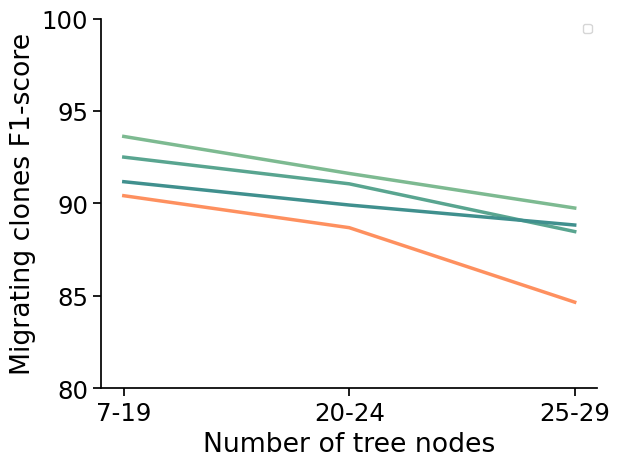

12:47:15 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 7 19 567
1 20 24 542
2 25 29 538


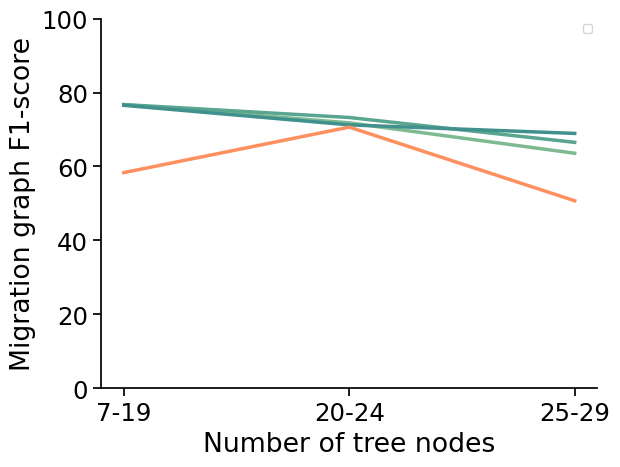

12:47:16 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 7 19 567
1 20 24 542
2 25 29 538


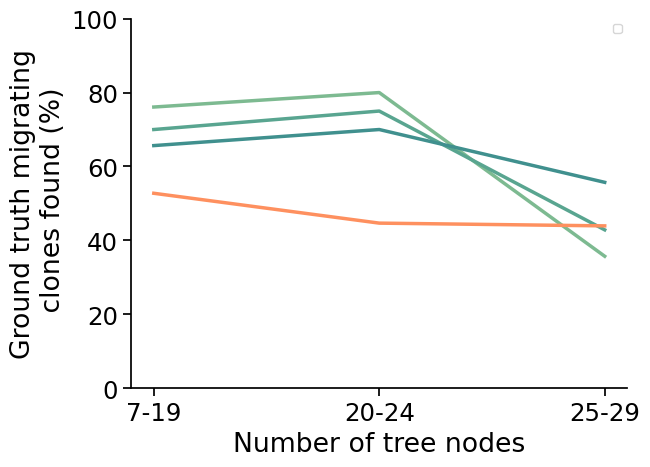

12:47:17 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 7 19 567
1 20 24 542
2 25 29 538


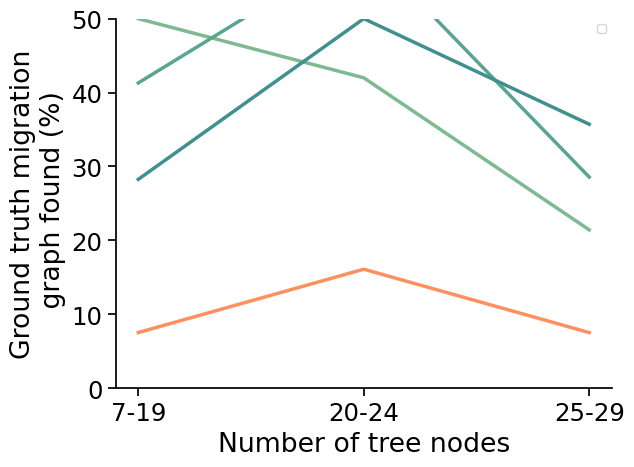

12:47:18 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


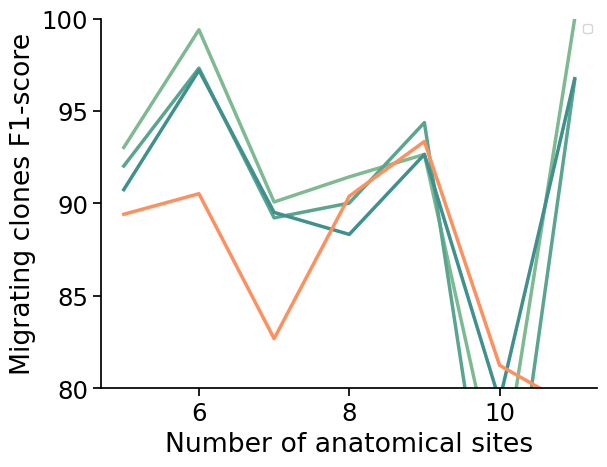

12:47:19 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


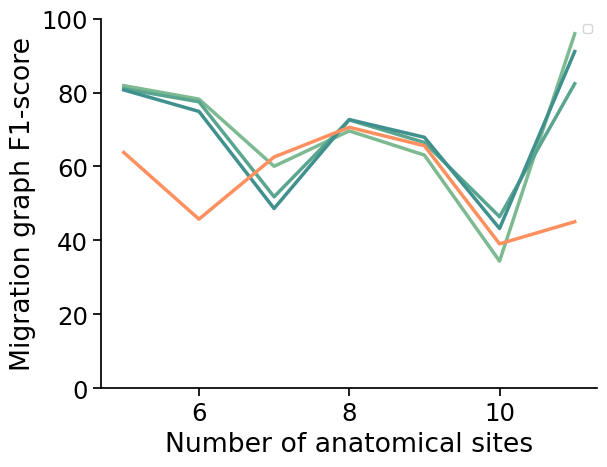

12:47:20 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


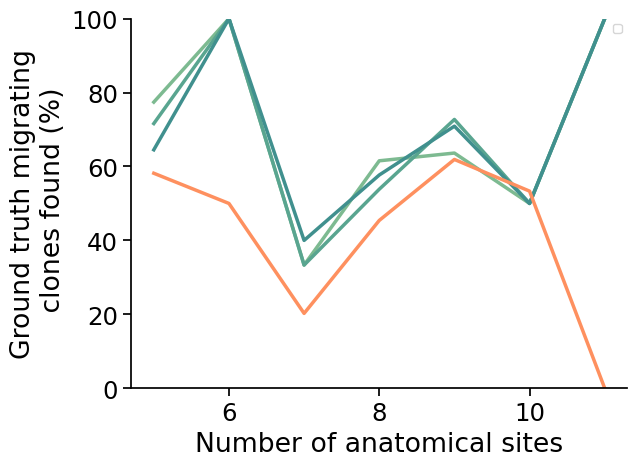

12:47:21 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


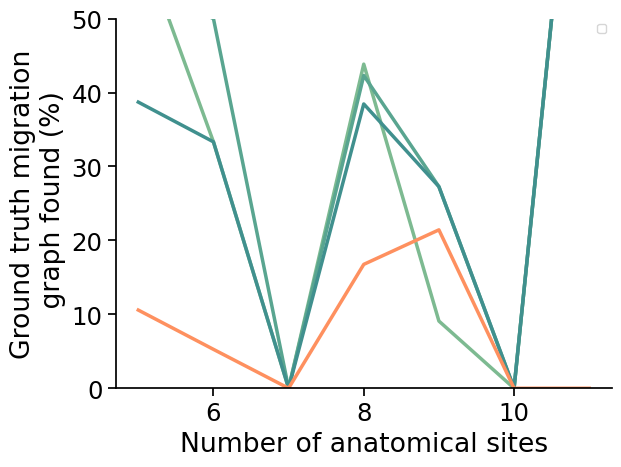

12:47:22 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 1.6e+04 1.8e+16 567
1 1.3e+17 8.9e+21 548
2 3.8e+22 1.4e+29 532


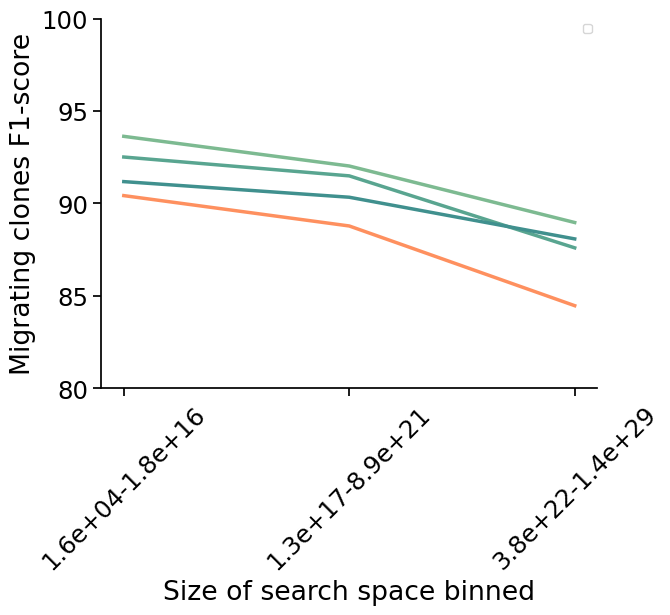

12:47:24 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 1.6e+04 1.8e+16 567
1 1.3e+17 8.9e+21 548
2 3.8e+22 1.4e+29 532


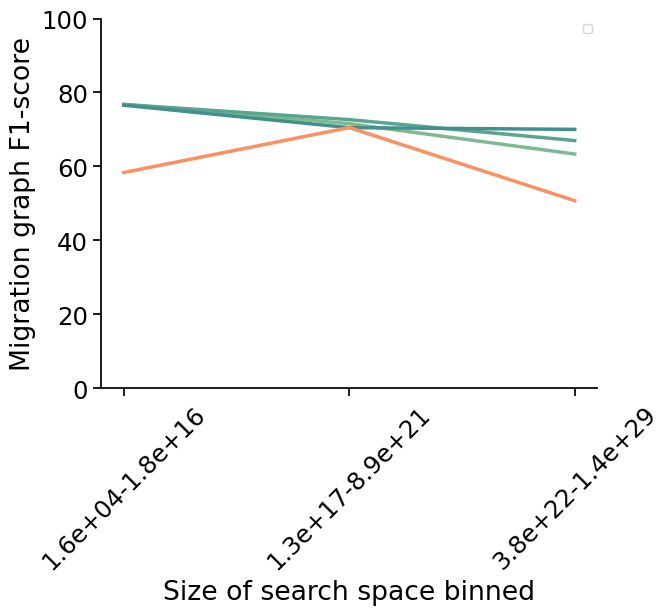

12:47:25 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 1.6e+04 1.8e+16 567
1 1.3e+17 8.9e+21 548
2 3.8e+22 1.4e+29 532


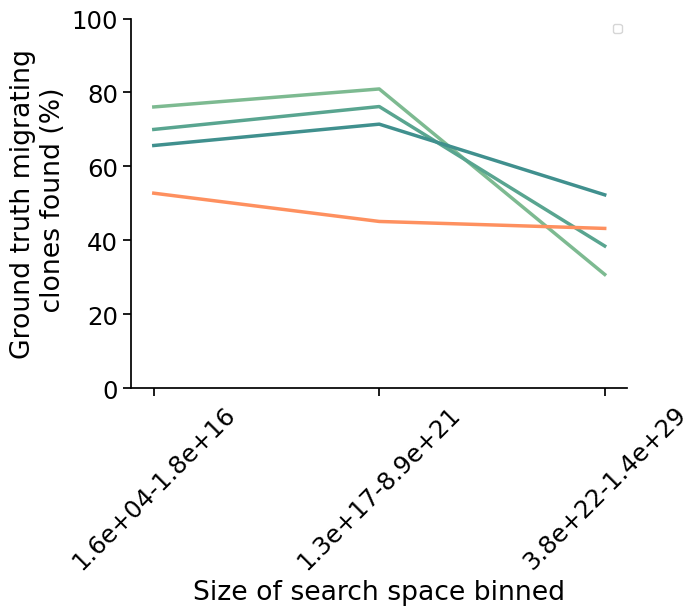

12:47:27 WARNING
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 1.6e+04 1.8e+16 567
1 1.3e+17 8.9e+21 548
2 3.8e+22 1.4e+29 532


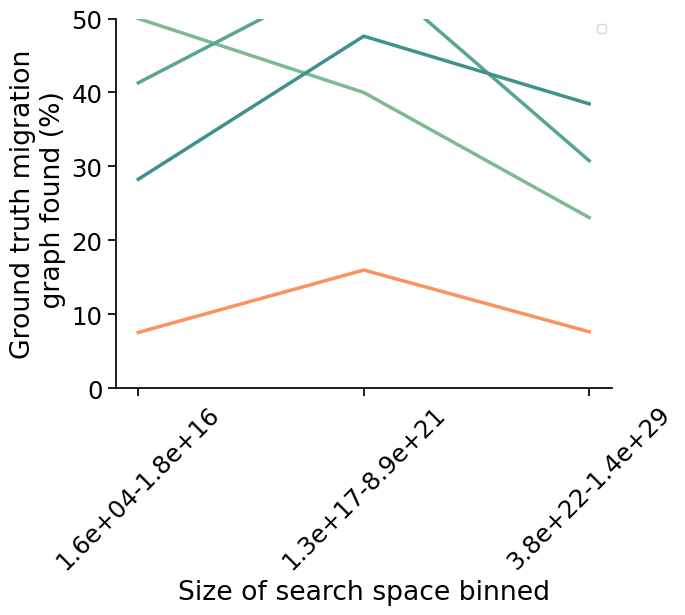

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("crest")
colors = colors[:len(methods)]
colors.append((0.99609375, 0.56640625, 0.37109375))
print(colors)
sns.set_palette(sns.color_palette(colors))

ys = ["Migrating clones F1-score", "Migration graph F1-score", "% time that migrating clone ground truth found", "% time that migration graph ground truth found"]
y_labels = ["Migrating clones F1-score", "Migration graph F1-score", "Ground truth migrating\n clones found (%)", "Ground truth migration\n graph found (%)"]
out_names = ["Migrating clones F1-score", "Migration graph F1-score", "Ground truth migrating clones found", "Ground truth migration graph found"]

def get_tree_node_bins():
    bin_numbers = sorted(list(cluster_num_df['cluster_bins'].unique()))
    bin_ranges = []
    for bin_num in bin_numbers:
        bin_min = cluster_num_df[cluster_num_df['cluster_bins']==bin_num]['clusters'].min()
        bin_max = cluster_num_df[cluster_num_df['cluster_bins']==bin_num]['clusters'].max()
        size = len(cluster_num_df[cluster_num_df['cluster_bins']==bin_num])
        bin_ranges.append(f"{bin_min}-{bin_max}")
        print(bin_num, bin_min, bin_max, size)
    return bin_numbers, bin_ranges

def get_prob_size_bins():
    bin_numbers = sorted(list(cluster_num_df['prob_size_bins'].unique()))
    bin_ranges = []
    for bin_num in bin_numbers:
        bin_min = cluster_num_df[cluster_num_df['prob_size_bins']==bin_num]['prob_size'].min()*denom
        bin_minf = "{:.1e}".format(bin_min)
        bin_max = cluster_num_df[cluster_num_df['prob_size_bins']==bin_num]['prob_size'].max()*denom
        bin_maxf = "{:.1e}".format(bin_max)
        size = len(cluster_num_df[cluster_num_df['prob_size_bins']==bin_num])
        bin_ranges.append(f"{bin_minf}-{bin_maxf}")
        print(bin_num, bin_minf, bin_maxf, size)
    return bin_numbers, bin_ranges

for x, df in zip(["Number of tree nodes", "Number of anatomical sites", "Size of search space binned"], [results1, results2, results3]):
    for i,y in enumerate(ys):
        with sns.plotting_context("notebook", font_scale=1.6):
            g = sns.lineplot(
                data=df, x=x, y=y, linewidth=2.5,
                hue="Method", legend=False,  
            )
            if x == "Number of tree nodes":
                bin_numbers, bin_ranges = get_tree_node_bins()
                plt.xticks(ticks=bin_numbers,labels=bin_ranges)
            if x == "Size of search space binned":
                bin_numbers, bin_ranges = get_prob_size_bins()
                plt.xticks(ticks=bin_numbers,labels=bin_ranges)
                plt.xticks(rotation=45)
            if x == "Size of search space":
                plt.xscale('log')
            
            if y == "% time that migration graph ground truth found":
                plt.ylim(0, 50)
            elif y == "Migrating clones F1-score":
                plt.ylim(80, 100)
            else:
                plt.ylim(0, 100)
                
            legend = g.legend(prop={'size': 8})  # Set the desired font size here
            g.spines['top'].set_visible(False)
            g.spines['right'].set_visible(False)
            
            plt.ylabel(y_labels[i])
            out_name = ("_").join(out_names[i].split(" ") + x.split(" "))

            plt.savefig(os.path.join(REPO_DIR, "test/output_plots", f"{out_name}_10runs_lossthres{LOSS_THRES}_{PARAMS}_{DATE}.png"), dpi=600, bbox_inches="tight", pad_inches=0.3) 

            plt.show()
